## Text Summarization using clustering of sentences

**DESCRIBE WHAT IS THE METHOD. CLUSTERING OF SENTENCES**



### Importing the libraries

I will use the rouge library to calculate the ROUGE metrics to evaluate the results.This library is independant from the "official" ROUGE script (aka. ROUGE-155) and results may be slighlty different,but it is very easy to use.


In [31]:
#!pip install rouge

In [63]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import random

from nltk.tokenize import sent_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

#Import library to calculate the evaluation metric
from rouge import FilesRouge, Rouge


#### Defining global variables

In [2]:
data_path='../data'
glove_file = 'glove.6B.100d.txt'
glove_filename = os.path.join(data_path, glove_file)

### Load the Word embeddings

We have to move the embeddings from Google Storage the first time we run this notebook

In [12]:
#%%bash
#gsutil cp gs://mlend_bucket/embeddings/glove.6B.100d.txt ../data

Copying gs://mlend_bucket/embeddings/glove.6B.100d.txt...
- [1 files][331.0 MiB/331.0 MiB]                                                
Operation completed over 1 objects/331.0 MiB.                                    


In [3]:
# Function to tokenize or split a text in sentences
def split_sentences(documents):
    """
    Splits the documents into individual sentences.
    Input:
       - documents: list of string to split into sentences
    Output:
        - list of list of strings (sentence)
    """
    docs_sentences=[]
    n_docs = len(documents)
    for i in range(n_docs):
        text = documents[i]
        #print(email)
        sentences = sent_tokenize(text)
        #print(sentences)
        for j in reversed(range(len(sentences))):
            sent = sentences[j]
            sentences[j] = sent.strip()
            if sent == '':
                sentences.pop(j)
        docs_sentences.append(sentences)
        
    return docs_sentences

### Loading the data

In [3]:
# Run only when new datafiles have been stored in GS
#%%bash
#gsutil cp gs://mlend_bucket/data/news_summary/news_summary_more.csv ../data/

In [67]:
summary = pd.read_csv('../data/news_summary.csv', encoding='iso-8859-1')
summary.head(5)

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [68]:
#Drop duplicate rows
summary.drop_duplicates(subset=["ctext"],inplace=True)
#Drop rows with null values in the text variable
summary.dropna(inplace=True)
summary.reset_index(drop=True,inplace=True)
# we are using the text variable as the summary and the ctext as the source text
dataset = summary[['text','ctext']].copy()
dataset.columns = ['summary','text']
dataset.head(5)

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


### Data preprocess and cleanings

Lets dive into the dataset to verify come cleanings we need to apply to our dataset.
- Expand contractions
- Puntuaction separation
- Remove multispaces


In [69]:
import re
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                       "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", 
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                       "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                       "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                       "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", 
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                       "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                       "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                       "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", 
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

punct = "/-'.,?!#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

def expand_contractions(text):
    ''' Expand the contractions (some well-known of them) in a text'''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

def remove_mult_spaces(text):
    re_mult_space = re.compile(r"  *") # replace multiple spaces with just one
    return re_mult_space.sub(r' ', text)

def sep_punctuation(text, punct):
# Separate punctuation with whitespaces
    for p in punct:
        text = text.replace(p, f'{p} ')

    return text

def remove_CTL(text):
    url = re.compile(r'\n')
    return url.sub(r' ',text)

def clean_text(text):
    new_text=text
    new_text=new_text.apply(lambda x : expand_contractions(x))
    new_text=new_text.apply(lambda x : sep_punctuation(x,punct))
    new_text=new_text.apply(lambda x : remove_mult_spaces(x))
    new_text=new_text.apply(lambda x : remove_CTL(x))
    return new_text


### Text cleaning and preprocess

In [70]:
dataset['text']=clean_text(dataset['text'])
dataset['summary']=clean_text(dataset['summary'])

## Word embeddings

**What is word embedding?**
Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation. They are a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.

Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning. The distributed representation is learned based on the usage of words. This allows words that are used in similar ways to result in having similar representations, naturally capturing their meaning. 

**How can we obtain the word embedings?**
1. **Embedding Layer**
An embedding layer is a word embedding that is learned in a neural network model on a specific natural language processing task. The documents or corpus of the task are cleaned and prepared and the size of the vector space is specified as part of the model, such as 50, 100, or 300 dimensions. The vectors are initialized with small random numbers. The embedding layer is used on the front end of a neural network and is fit in a supervised way using the Backpropagation algorithm. 

This approach requires a lot of training data and can be very slow, but will learn an embedding both targeted to the specific text data and the NLP task

2. **Word2Vec**
Word2Vec is a statistical method for efficiently learning a standalone word embedding from a text corpus. It was developed by Tomas Mikolov, et al. at Google in 2013 as a response to make the neural-network-based training of the embedding more efficient and since then has become the de facto standard for developing pre-trained word embedding.

It learns the word embedding in one of two ways, either using context to predict a target word (a method known as continuous bag of words, or CBOW), or using a word to predict a target context, which is called skip-gram. The latter method usually produces more accurate results on large datasets.

A well trained set of word vectors will place similar words close to each other in that space. The words oak, elm and birch might cluster in one corner, while war, conflict and strife huddle together in another.

3. **Glove**
The Global Vectors for Word Representation, or GloVe, algorithm is an extension to the word2vec method for efficiently learning word vectors, developed by Pennington, et al. at Stanford. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

GloVe is an approach to marry both the global statistics of matrix factorization techniques like LSA (Latent Semantic Analysis) with the local context-based learning in word2vec. Rather than using a window to define local context, GloVe constructs an explicit word-context or word co-occurrence matrix using statistics across the whole text corpus.

Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. 
https://nlp.stanford.edu/pubs/glove.pdf

### Making the vocabulary and tokenize the texts


In [6]:
#### NOOOOOOOOOOOOOO ############

#Making vocabulary with reviews with max vocabs=5000. 
vocab_size=5000
sequence_length = 200
#Create the train dataset
train_text = dataset['text']
#DEfine the tokenizer and tokenize the train dataset
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(list(train_text))
list_tokenized_train = tokenizer.texts_to_sequences(train_text)
# Padding the sequence of tokens
padded_train = pad_sequences(list_tokenized_train, maxlen=sequence_length)

### Loading a pre-trained word embedding: GloVe

**Describe the estructure of the data and where to find**

First we convert the GloVe file containing the word embeddings to the word2vec format for convenience of use. We can do it using the gensim library, a function called glove2word2vec.

So our vocabulary contains 400K words represented by a feature vector of shape 100. Now we can load the Glove embeddings in word2vec format and then analyze some analogies. In this way if we want to use a pre-trained word2vec embeddings we can simply change the filename and reuse all the code below.

In [10]:
########## NOOOOO ############
from gensim.models import KeyedVectors

# load the Stanford GloVe model
#word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

#Show a word embedding
print('King embedding: ',model.get_vector('king'))

result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

King embedding:  [-0.32307  -0.87616   0.21977   0.25268   0.22976   0.7388   -0.37954
 -0.35307  -0.84369  -1.1113   -0.30266   0.33178  -0.25113   0.30448
 -0.077491 -0.89815   0.092496 -1.1407   -0.58324   0.66869  -0.23122
 -0.95855   0.28262  -0.078848  0.75315   0.26584   0.3422   -0.33949
  0.95608   0.065641  0.45747   0.39835   0.57965   0.39267  -0.21851
  0.58795  -0.55999   0.63368  -0.043983 -0.68731  -0.37841   0.38026
  0.61641  -0.88269  -0.12346  -0.37928  -0.38318   0.23868   0.6685
 -0.43321  -0.11065   0.081723  1.1569    0.78958  -0.21223  -2.3211
 -0.67806   0.44561   0.65707   0.1045    0.46217   0.19912   0.25802
  0.057194  0.53443  -0.43133  -0.34311   0.59789  -0.58417   0.068995
  0.23944  -0.85181   0.30379  -0.34177  -0.25746  -0.031101 -0.16285
  0.45169  -0.91627   0.64521   0.73281  -0.22752   0.30226   0.044801
 -0.83741   0.55006  -0.52506  -1.7357    0.4751   -0.70487   0.056939
 -0.7132    0.089623  0.41394  -1.3363   -0.61915  -0.33089  -0.52881
  

In [15]:
model.get_vector('º')

KeyError: "word 'º' not in vocabulary"

## Applying the word embedding to a text for a NLP task

Now, we have our word representation, a vector for every word in our vocabulary. But we need to deal with full sentences so we need to create a sentence embedding, basically we need a vector that represent the whole sentence and every feature in the vector will be based on the subyacent word embeddings. There are many posibilities and we are notr going to cover this topic, so we apply a very simple method: the ith value in the sentence embedding will be the mean of the ith values in the word embedding of all the words in the sentence. 

**Explain how to transform from words to sentence**

In [12]:
###   NOOOOOOO ####

# A Class similar to a tokenizer, store a Word2Vec model or embeddings and transform a received 
# list of tokens to a list of embeddings
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

Create a Class that load the Glove embeddings and generates the word2vec (mapping words to embedding vector). The Class defines a function to transforme a list of sentences to a list of embeddings vectors

In [6]:
class GloveVectorizer:
  def __init__(self, embedding_file):
    # load in pre-trained word vectors
    print('Loading word vectors...')
    word2vec = {}
    embedding = []
    idx2word = []
    with open(embedding_file) as f:
      # is just a space-separated text file in the format:
      # word vec[0] vec[1] vec[2] ...
      for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        embedding.append(vec)
        idx2word.append(word)
    print('Found %s word vectors.' % len(word2vec))

    # save for later
    self.word2vec = word2vec
    self.embedding = np.array(embedding)
    self.word2idx = {v:k for k,v in enumerate(idx2word)}
    self.V, self.D = self.embedding.shape

  def fit(self, data):
    pass

  def transform(self, data):
    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.lower().split()
      vecs = []
      for word in tokens:
        if word in self.word2vec:
          vec = self.word2vec[word]
          vecs.append(vec)
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    #print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)


In [22]:
#vectorizer.word2vec['king']
#model.get_vector('king')==vectorizer.word2vec['king']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

The next function creates the summary for a given sentence and its embedding vectors

In [7]:
# ,,Xtrain,text_sentence[0]
def select_summary_sents(n_clusters, kmeans, emb_sentence, sentence):

    avg = []
    for j in range(n_clusters):
        idx = np.where(kmeans.labels_ == j)[0]
        avg.append(np.mean(idx))
        
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, emb_sentence)
    ordering = sorted(range(n_clusters), key=lambda k: avg[k])
    #summary = ' '.join([email[closest[idx]] for idx in ordering])
    summary = [sentence[closest[idx]] for idx in ordering]
    return summary

def generate_summaries(list_sentences, embedding_vectors):
    ''' This is the main function, where the algorithm is applied. Create a summary for every document
        in the list of sentences using the embedding vectors to transform word into numerical values.
        
        input:
           - list_sentences: a list of list of string where very list of string are the sentences in a doc
           - embedding_vectors: the embeddings used to map token or words into numerical vectors
        Output:
           - n_clusters: the k value used for every doc in the kmeans algorithm
           - summary_sentences: a list of list of string, the list of sentences in every summary
    '''
    # Initialize every output list
    n_clusters=[]
    summary_sentences=[]
    #Lets create the summary for every document
    for text in list_sentences:
    #Generate the sentence embedding for every sentence in the text
        emb_sentences = vectorizer.fit_transform(text)
    #The number of cluster is equal to squqre root of the number of sentences
        k = int(np.ceil(len(emb_sentences)**0.5))
    # Apply Kmeans clustering to thr sentences in the document
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans = kmeans.fit(emb_sentences)
    # Select the sentence appropiate in every cluster discovered
        sentences = select_summary_sents(k, kmeans, emb_sentences, text)
        n_clusters.append(k)
        summary_sentences.append(sentences)
        
    return n_clusters, summary_sentences
  
    

In [8]:
dataset['text'].values[:5]

array(['The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by t

In [71]:
#Split every document into a list of sentences
dataset['list_sentences'] = split_sentences(dataset['text'].values)
#Load the Glove embeddings
vectorizer = GloveVectorizer(glove_filename)
#Lets create the summary for every document
list_sent = dataset['list_sentences'].values
n_clusters, summary_sentences = generate_summaries(list_sent, vectorizer)
# Transform the list of sentences of the summary to a single string
#summary = ' '.join([sent for sent in summary_sentences])
summary = [' '.join([sent for sent in sentences]) for sentences in summary_sentences]
#Store the values in the dataset
dataset['n_clusters']=n_clusters
dataset['summary_sents']=summary_sentences
dataset['pred_summary']=summary


Loading word vectors...
Found 400000 word vectors.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (15). Possibly due to duplicate points in X.
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [72]:
dataset.head(5)

,summary,text,list_sentences,n_clusters,summary_sents,pred_summary
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...,[The Daman and Diu administration on Wednesday...,6,"[?, The Daman and Diu administration on Wednes...",? The Daman and Diu administration on Wednesda...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV? appearances, B...","[From her special numbers to TV?, appearances,...",6,"[rich man?, ., alumni?, # khannajewellers., Bu...",rich man? . alumni? # khannajewellers. But we ...
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...,[The Indira Gandhi Institute of Medical Scienc...,6,"[after controversy., virgin?, because it simpl...",after controversy. virgin? because it simply m...
3,Lashkar- e- Taiba' s Kashmir commander Abu Duj...,Lashkar- e- Taiba' s Kashmir commander Abu Duj...,[Lashkar- e- Taiba' s Kashmir commander Abu Du...,6,"[Surrender kyun nahi kar deta., After initiati...",Surrender kyun nahi kar deta. After initiating...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...,[Hotels in Mumbai and other Indian cities are ...,5,"[We are committed to this cause. "", Vijaya Rah...","We are committed to this cause. "" Vijaya Rahat..."


Next step, transform a sentence to a list of embeddings vector. There will be one vector for every word or token in the sentence

### Evaluating the results using ROUGE metrics 

**DESCRIBE ROUGE METRIC**

#### Create predicted and real summaries file

In [73]:
def save_textfile(filename, strings):
    ''' Save the contect of a list of strings to a file called filename
    
        Input:
           - filename: name of the file to save the strings
           - strings: a list of string to save to disk
    '''
    
    with open(filename, 'w') as f:
        for item in strings:
            #Remove any \n in the string
            item = remove_CTL(item)
            f.write("%s\n" % item)

def eval_metrics(preds, targets, avg=True):
    ''' Evaluate the ROUGE metrics ROUGE-2 and ROUGE-L for every pair predicted summary - target summary
    
        Input:
           - preds: list of strings, predicted summaries
           - targets: list of string, target summaries
        Output:
            - rouge2_f_metric: list of float, the Rouge-2 fscore for every predicted summary
            - rougel_f_metric: list of float, the Rouge-L fscore for every predicted summary
    '''
    #Lets calculate the rouge metrics for every document
    rouge = Rouge()
    scores = rouge.get_scores(preds, targets, avg)
    # Create the output variables
    if avg:
        rouge2_f_metric = scores['rouge-2']['f']
        rougel_f_metric = scores['rouge-l']['f']
    else:
        rouge2_f_metric = [score['rouge-2']['f'] for score in scores]
        rougel_f_metric = [score['rouge-l']['f'] for score in scores]
       
    
    return rouge2_f_metric, rougel_f_metric
    

In [74]:
predicted_summaries=summary
labeled_summaries = list(dataset['summary'].values)

In [78]:
#Save the files with the predicted summaries
save_textfile('predicted_summaries.txt',predicted_summaries)
save_textfile('labeled_summaries.txt',labeled_summaries)

When the files with the predicted and real summaries are stored, withone summary per line, we can call the rouge library to get the metrics for our evaluation method.
Lets try it,

In [79]:
#Create the rouge object and scores the ROUGE metrics in average 
files_rouge = FilesRouge()
scores = files_rouge.get_scores('predicted_summaries.txt', 'labeled_summaries.txt', avg=True)
#print('Average Results on the Test set:\n')
print(scores)

{'rouge-1': {'f': 0.32056875525955664, 'p': 0.3172510842869118, 'r': 0.3522820083122381}, 'rouge-2': {'f': 0.1244346442333612, 'p': 0.12367044025445732, 'r': 0.13593267853288318}, 'rouge-l': {'f': 0.28618975836790767, 'p': 0.281154216131219, 'r': 0.3107627614537229}}


In [80]:
r2_f, rl_f = eval_metrics(predicted_summaries, labeled_summaries, False)
#print(r2_f,rl_f)
dataset['rouge2-f'] = r2_f
dataset['rougeL-f'] = rl_f


In [61]:
dataset['rouge2-f']

0       0.318471
1       0.067227
2       0.074074
3       0.000000
4       0.019002
          ...   
4336    0.531250
4337    0.261905
4338    0.028846
4339    0.129032
4340    0.173913
Name: rouge2-f, Length: 4341, dtype: float64

**Code to check the count of lines in the files**

In [77]:
fname = "predicted_summaries.txt"
count = 0
with open(fname, 'r') as f:
    for line in f:
        count += 1
print("Total number of lines is:", count)

Total number of lines is: 4341


### Visualization of results

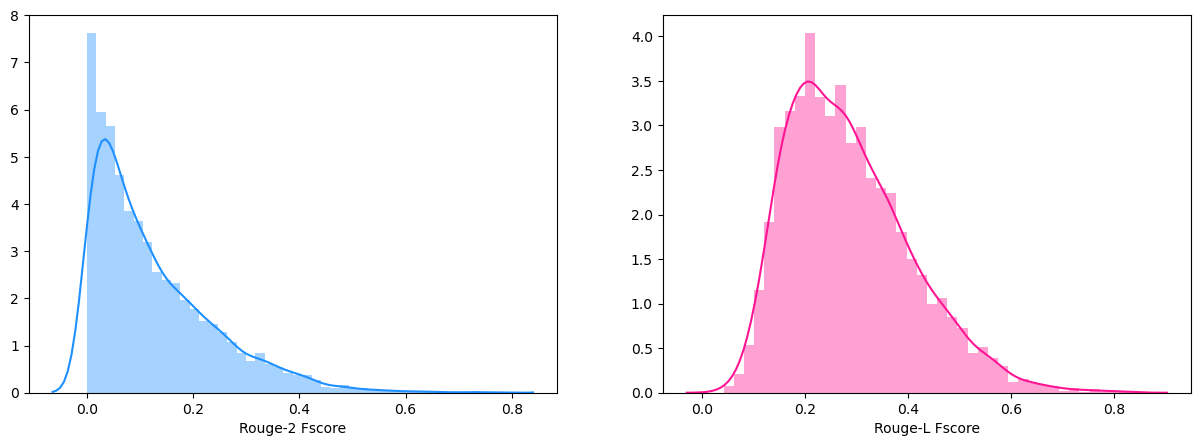

In [81]:
# Plot
kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})
# plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False, dpi=100)
sns.distplot(dataset['rouge2-f'] , color="dodgerblue", ax=axes[0], axlabel='Rouge-2 Fscore')
sns.distplot(dataset['rougeL-f'], color="deeppink", ax=axes[1], axlabel='Rouge-L Fscore')

